### Carga e Transformações nos Dados

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#Carregando os dados
df = pd.read_csv("dados/dados_merge.csv", header=None)

#Definindo os nomes de colunas para evitar b.o futuramente
colunas = [
    "venda_id", "data_venda", "produto_id", "cliente_id", "quantidade",
    "preco_unitario", "desconto", "valor_total", "loja_id", "canal_venda",
    "metodo_pagamento", "dia_semana", "mes", "ano", "trimestre", "nome_cliente",
    "idade", "genero", "cep", "data_cadastro", "frequencia_compra", "nome_produto",
    "categoria_produto", "subcategoria_produto", "custo", "preco", "marca"
]

df.columns = colunas

#Convertendo para os tipos de dados apropriados
df["data_venda"] = pd.to_datetime(df["data_venda"], errors='coerce')
df["data_cadastro"] = pd.to_datetime(df["data_cadastro"], errors='coerce')

#Convertendo os campos numéricos
df["valor_total"] = pd.to_numeric(df["valor_total"], errors='coerce')
df["quantidade"] = pd.to_numeric(df["quantidade"], errors='coerce')
df["idade"] = pd.to_numeric(df["idade"], errors='coerce')

#Removendo as linhas que tem valores nulos importantes
df.dropna(subset=["data_venda", "produto_id", "quantidade", "valor_total"], inplace=True)

#Visualizando algumas informações do df
print(df.info())
print("\nPrimeiras linhas do dataset:")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   venda_id              10000 non-null  object        
 1   data_venda            10000 non-null  datetime64[ns]
 2   produto_id            10000 non-null  object        
 3   cliente_id            10000 non-null  object        
 4   quantidade            10000 non-null  float64       
 5   preco_unitario        10000 non-null  object        
 6   desconto              10000 non-null  object        
 7   valor_total           10000 non-null  float64       
 8   loja_id               10000 non-null  object        
 9   canal_venda           10000 non-null  object        
 10  metodo_pagamento      10000 non-null  object        
 11  dia_semana            10000 non-null  object        
 12  mes                   10000 non-null  object        
 13  ano                  

### Pré Processamento dos Dados

In [ ]:
#Criando a nova feature: dias desde o cadastro do cliente
df['dias_desde_cadastro'] = (df['data_venda'] - df['data_cadastro']).dt.days

#Convertendo as colunas para numérico e substituo os valores inválidos por "NaN"
df['preco_unitario'] = pd.to_numeric(df['preco_unitario'], errors='coerce')
df['desconto'] = pd.to_numeric(df['desconto'], errors='coerce')

#Removendo as linhas com valores nulos nas colunas abaixo
df.dropna(subset=["preco_unitario", "desconto"], inplace=True)

#Calculando o preço efetivo
df['preco_efetivo'] = df['preco_unitario'] * (1 - df['desconto'])

#Criando uma nova feature: preço efetivo após desconto
df['preco_efetivo'] = df['preco_unitario'] * (1 - df['desconto'])

#Codificando as variáveis categóricas
df = pd.get_dummies(df, columns=[
    'canal_venda', 
    'metodo_pagamento', 
    'dia_semana', 
    'frequencia_compra', 
    'categoria_produto', 
    'subcategoria_produto',
    'genero'
])

#Selecionando as features relevantes para o modelo
features = ['produto_id', 'cliente_id', 'idade', 'dias_desde_cadastro', 'preco_unitario', 
            'desconto', 'preco_efetivo', 'mes', 'ano', 'trimestre'] + \
           [col for col in df.columns if col.startswith(('canal_venda', 'metodo_pagamento', 'dia_semana', 'frequencia_compra', 'categoria_produto', 'subcategoria_produto', 'genero'))]

X = df[features]
y = df['quantidade']

#Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Normalizando as features numéricas
scaler = StandardScaler()
numeric_features = ['idade', 'dias_desde_cadastro', 'preco_unitario', 'desconto', 'preco_efetivo', 'mes', 'ano', 'trimestre']
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

### Treinamento do Modelo

Mean Absolute Error: 1.26
R² Score: -0.03


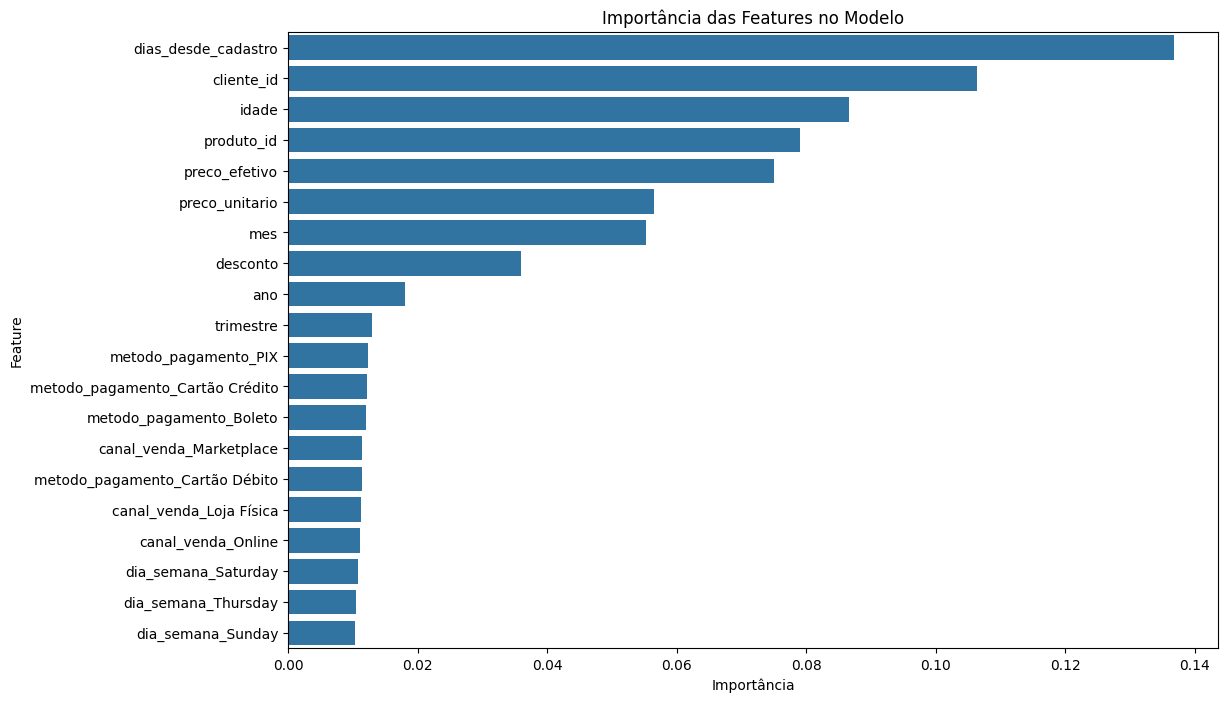

In [ ]:
#Treinando o modelo (escolhi o Random Forest)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

#Fazendo as previsões
y_pred = rf_model.predict(X_test)

#Avaliando o modelo
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

#Visualizando a importância das features
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Importância das Features no Modelo")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.show()

### Análise de Resultados

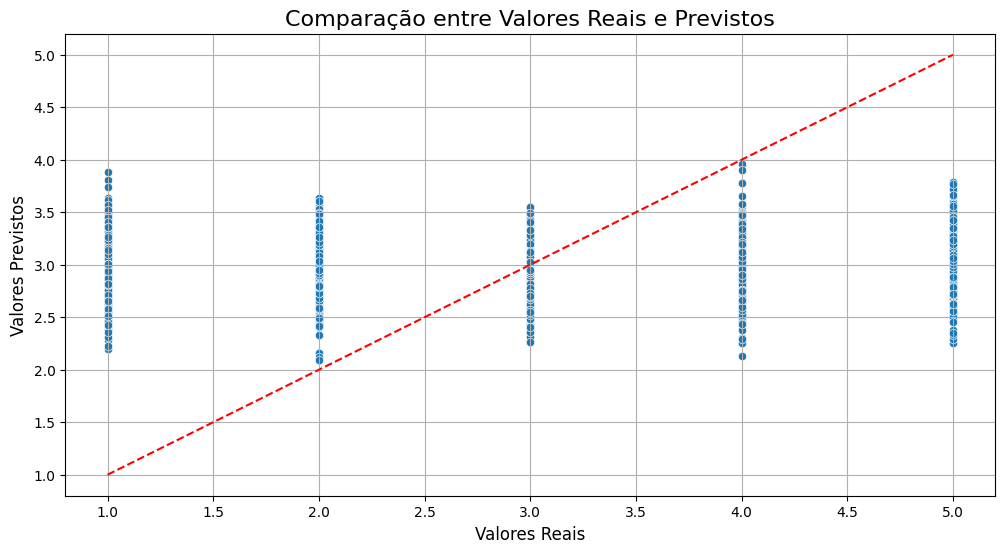

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Criando um df com os valores reais e previstos
comparison_df = pd.DataFrame({
    'Real': y_test,
    'Previsto': y_pred
})

#Criando o gráfico
plt.figure(figsize=(12, 6))
sns.scatterplot(data=comparison_df, x='Real', y='Previsto')
plt.plot([min(comparison_df['Real']), max(comparison_df['Real'])],
         [min(comparison_df['Real']), max(comparison_df['Real'])], 
         color='red', linestyle='--')

plt.title("Comparação entre Valores Reais e Previstos", fontsize=16)
plt.xlabel("Valores Reais", fontsize=12)
plt.ylabel("Valores Previstos", fontsize=12)
plt.grid(True)
plt.show()